# Test for Streamlit

## IMPORT LIBRARIES

In [160]:
import streamlit as st
import os
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import load_img

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

## LOAD DATA

In [161]:
# dataframe where we will get product information
all = pd.read_csv(r'./../data/cleaned_data/filtered_all4.csv')

In [162]:
# labels for each product which would be needed when trying to get recommendations for each general product category
labels = pd.read_csv(r'./../data/cleaned_data/labels.csv')

In [163]:
# unique values in the category column, arranged in alphabetical order
class_labels = sorted(list(all.category.unique()))

In [164]:
class_labels

['accessories',
 'bag',
 'bottom',
 'coat',
 'dress_overalls',
 'jewelry',
 'jumper',
 'top']

In [165]:
labels

,category
0,4
1,7
2,7
3,5
4,4
...,...
5873,7
5874,6
5875,2
5876,7


In [166]:
# transform it to a serie
labels = pd.Series(labels.category)

In [167]:
labels

0       4
1       7
2       7
3       5
4       4
       ..
5873    7
5874    6
5875    2
5876    7
5877    1
Name: category, Length: 5878, dtype: int64

In [168]:
# load previously saved matrices
images = np.load(r'./../streamlit/images.npy') # normalized image array to show images
scaled_embeddings = np.load(r'./../streamlit/scaled_embeddings.npy') # scaled embeddings to used to calculate the similarities

In [169]:
images.shape

(5878, 224, 224, 3)

In [170]:
scaled_embeddings.shape

(5878, 25088)

## FUNCTIONS

In [171]:
def get_image_embedding(image):
    """This function will perform the transformation needed for new images in order to compare it to the existing dataset"""
    image = image.resize((224, 224))
    image = np.array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    image_norm = image.astype('float32') / 255.0
    embed_image = intermediate_layer_model.predict(image_norm)
    embedded_matrix = np.array([image.flatten() for image in embed_image])
    #scaled = StandardScaler().fit_transform(embedded_matrix)
    return embedded_matrix

In [172]:
def get_similar_products(embedding1, embedding2, num_similar=5):
    """This function will, by default, look for the top 5 most similar products in the existing image embedding matrix
    in relation to the new input image."""
    similarities = cosine_similarity(embedding1, embedding2)
    
    # Sort the product scores in descending order
    most_similar = np.argsort(similarities[0])[::-1][:num_similar]
    sorted_scores = embedding2[most_similar]
    
    # Retrieve the top similar products and their scores
    similar_products = embedding2[most_similar]
    similar_scores = similarities[0][most_similar]
    
    return most_similar, similar_scores

In [173]:
def complete_outfit(embedding1, embedding2, labels, num_similar=8):
    # Get the similarity scores of the given product with all other products
    similarities = cosine_similarity(embedding1, embedding2)

    # Sort the product scores in descending order
    most_similar = np.argsort(similarities[0])[::-1]

    # Dictionary to store selected products per category
    selected_products = {}

    # List to store the final selected similar products
    similar_products = []

    # Counter to keep track of how many items have been selected for each label
    label_counter = {label: 0 for label in range(8)}

    for index in most_similar:
        category = labels[index]
        if label_counter[category] < 1:
            similar_products.append(index)
            selected_products[category] = index
            label_counter[category] += 1

        if len(similar_products) >= num_similar:
            break

    # Get the similarity scores of the selected products
    similar_scores = similarities[0][similar_products]

    return similar_products, similar_scores


In [174]:
# Function to visualize the distribution, mean and median of each continuous variable.
def show_similar_products(similar_products, product_score):
    a = math.ceil(len(similar_products)/3)  # number of rows
    b = 3  # number of columns
    c = 1  # initialize plot counter

    fig = plt.figure(figsize = (14, a*5))
    plt.suptitle("Similar Products", fontsize = 15, y=1)
    plt.grid(False)

    for s, p in zip(similar_products, product_score): 
        plt.subplot(a, b, c)
        fig = plt.imshow(images[s])
        plt.title(class_labels[labels[s]])
        plt.xlabel(f"Similarity : {p:.3f}")
        c = c + 1

    plt.tight_layout()
    plt.show()

In [175]:
def prod_details(index_list):
    """This function will show the product details which would be prodided in the streamlit app"""

    # empty lists to store infos
    prods = []
    brands = []
    prices = []
    links = []
    images = []

    for index in range(0, len(index_list)):

            product_name = all['product'][index_list[index]]
            prods.append(product_name)

            brand =  all['brand'][index_list[index]]
            brands.append(brand)

            price = all['orig_price'][index_list[index]]
            prices.append(price)

            link = all['link'][index_list[index]]
            links.append(link)

            image = all['img'][index_list[index]]
            images.append(image)
    
    for idx in range(0, len(index_list)):
        po, b, pi, l, i = prods[idx], brands[idx], prices[idx], links[idx], images[idx]
        print(f"**Product {idx+1}:**")
        print(f"**Product Brand:** {b}")
        print(f"**Product Name:** {po}")
        print(f"**Price:** €{pi}")
        print(f"**Link:** [{po}](https://www.smallable.com{l})")
        print("")  # Add an empty line for spacing between products
        idx += 1

In [176]:
# Load the VGG16 model with pre-trained weights (excluding the fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False)

# Create an intermediate layer model to obtain embeddings from the fully connected layer
intermediate_layer_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

## TRYING OUT THE CODE AND FUNCTIONS

In [177]:
# new image input
image_path = "/Users/rachelleflores/Downloads/final_project/data/smallable_images/try1.png"

In [178]:
# load image
new = load_img(image_path)

In [179]:
emb1 = get_image_embedding(new)

1/1 [==============================] - 0s 210ms/step


In [180]:
# check if the number of columns for both embedding matrices are the same
emb1.shape

(1, 25088)

In [181]:
scaled_embeddings.shape

(5878, 25088)

In [182]:
# top 5 most similar products
prod, score = get_similar_products(emb1, scaled_embeddings)

/var/folders/8z/6dxd_gws0p1gkky66vd1t2xh0000gn/T/ipykernel_69143/2665587290.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(a, b, c)


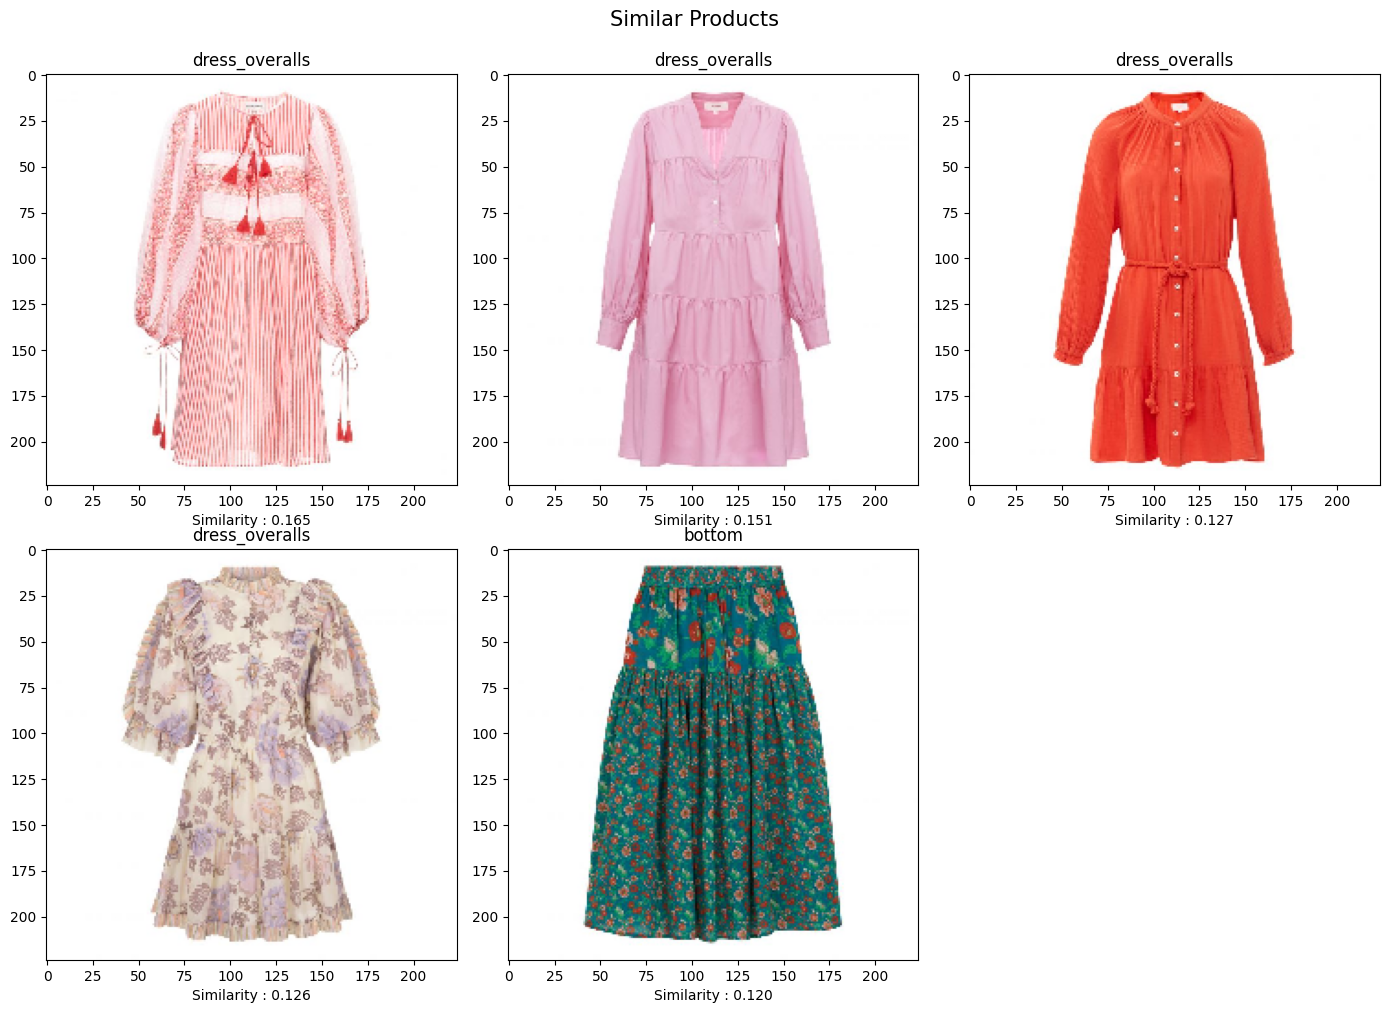

In [183]:
show_similar_products(prod, score)

In [184]:
prod_details(prod)

**Product 1:**
**Product Brand:** antik batik
**Product Name:** amelie mini dress
**Price:** €195.0
**Link:** [amelie mini dress](https://www.smallable.com/en/product/amelie-mini-dress-pink-antik-batik-302033)

**Product 2:**
**Product Brand:** xirena
**Product Name:** tallulah dress
**Price:** €384.0
**Link:** [tallulah dress](https://www.smallable.com/en/product/tallulah-dress-pink-xirena-299765)

**Product 3:**
**Product Brand:** xirena
**Product Name:** rainey cotton gauze dress
**Price:** €387.0
**Link:** [rainey cotton gauze dress](https://www.smallable.com/en/product/rainey-cotton-gauze-dress-mandarin-xirena-306776)

**Product 4:**
**Product Brand:** magali pascal
**Product Name:** andrina cotton and silk dress
**Price:** €405.0
**Link:** [andrina cotton and silk dress](https://www.smallable.com/en/product/andrina-cotton-and-silk-dress-ecru-magali-pascal-308229)

**Product 5:**
**Product Brand:** leon & harper
**Product Name:** jeannot gipsy organic cotton skirt
**Price:** €165.

In [185]:
# most similar product in each category
prod2, score2 = complete_outfit(emb1, scaled_embeddings, labels)

/var/folders/8z/6dxd_gws0p1gkky66vd1t2xh0000gn/T/ipykernel_69143/2665587290.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(a, b, c)


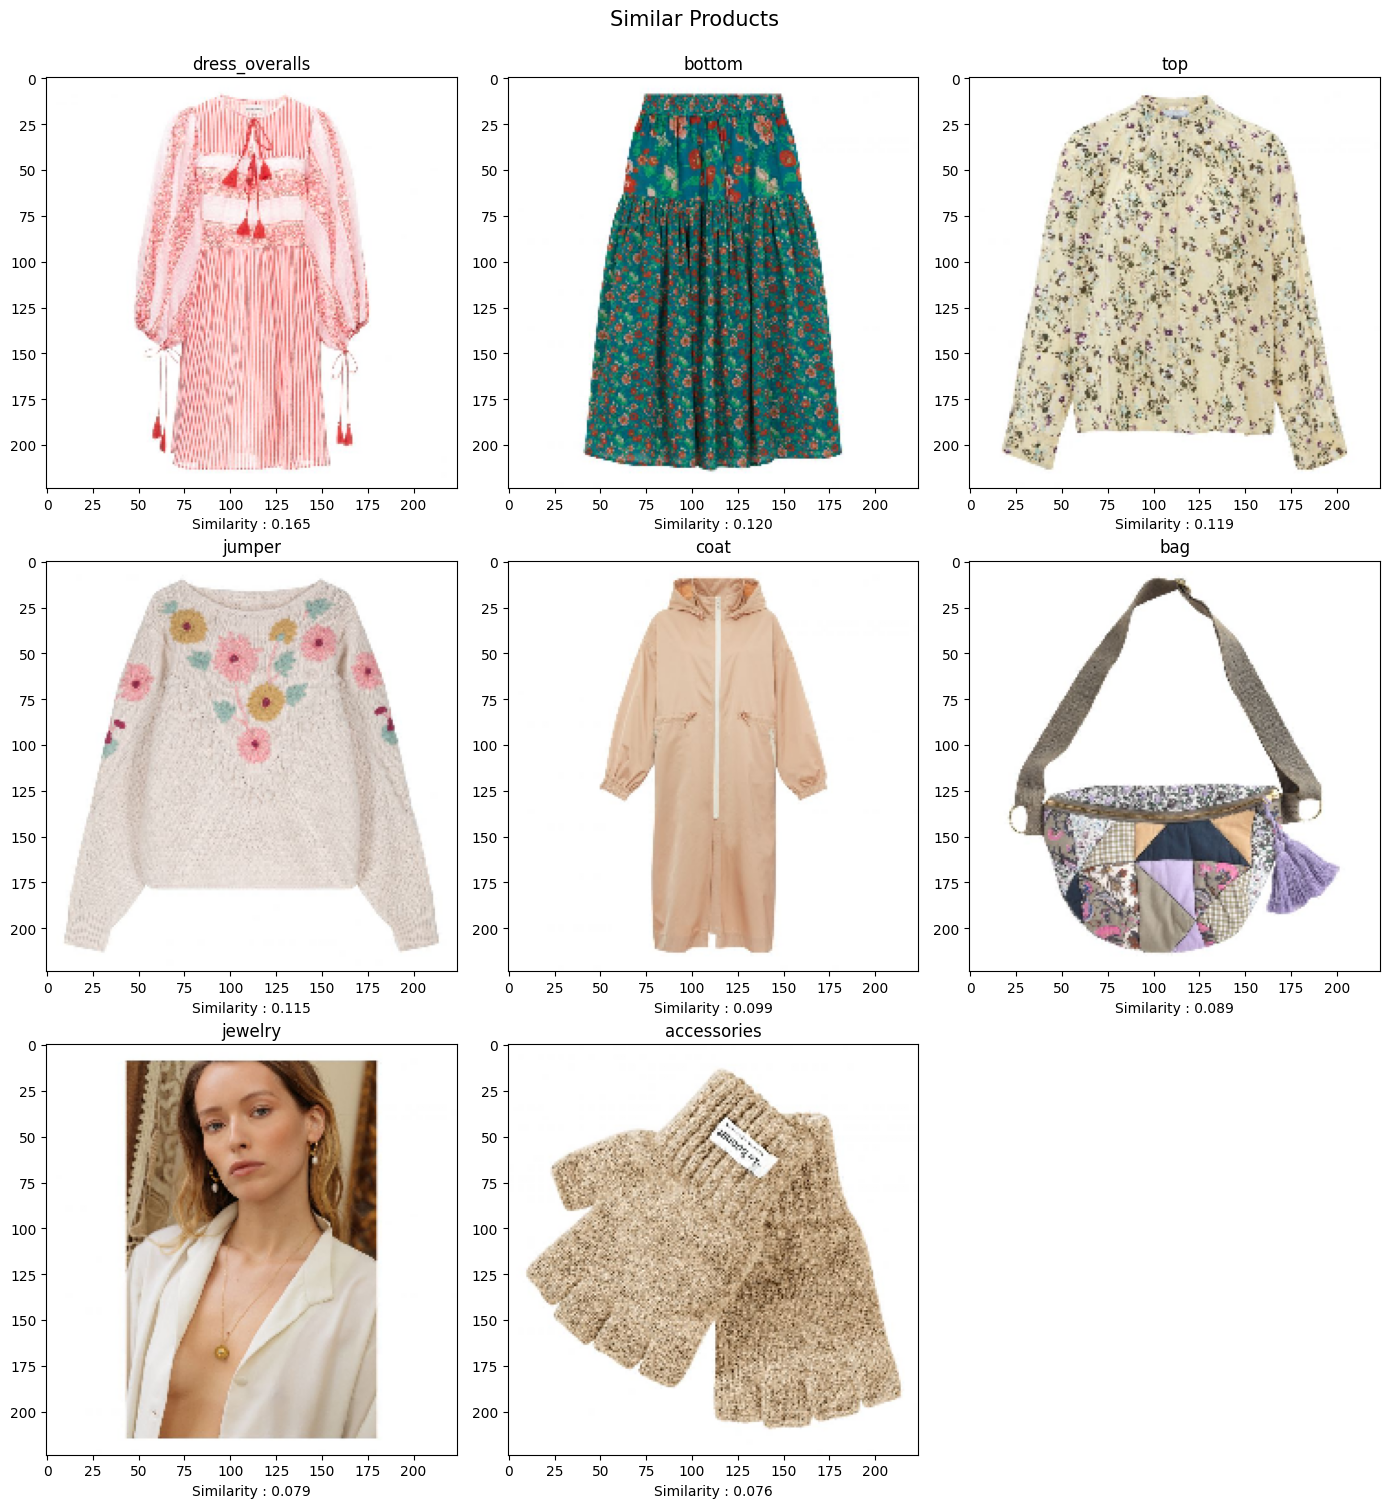

In [186]:
show_similar_products(prod2, score2)

In [187]:
prod_details(prod2)

**Product 1:**
**Product Brand:** antik batik
**Product Name:** amelie mini dress
**Price:** €195.0
**Link:** [amelie mini dress](https://www.smallable.com/en/product/amelie-mini-dress-pink-antik-batik-302033)

**Product 2:**
**Product Brand:** leon & harper
**Product Name:** jeannot gipsy organic cotton skirt
**Price:** €165.0
**Link:** [jeannot gipsy organic cotton skirt](https://www.smallable.com/en/product/jeannot-gipsy-organic-cotton-skirt-green-leon-harper-311331)

**Product 3:**
**Product Brand:** laurence bras
**Product Name:** printed shirt
**Price:** €199.0
**Link:** [printed shirt](https://www.smallable.com/en/product/printed-shirt-ecru-laurence-bras-305287)

**Product 4:**
**Product Brand:** louise misha
**Product Name:** pull brode main acai - collection femme 
**Price:** €160.0
**Link:** [pull brode main acai - collection femme ](https://www.smallable.com/en/product/pull-brode-main-acai-collection-femme-ecru-louise-misha-321334)

**Product 5:**
**Product Brand:** belleros